In [57]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
import numpy as np
import pymc3 as pm

from pyei.data import Datasets
from pyei.two_by_two import TwoByTwoEI
from pyei.goodmans_er import GoodmansER
from pyei.goodmans_er import GoodmansERBayes
from pyei.r_by_c import RowByColumnEI

from pyei.plot_utils import tomography_plot
from pyei.plot_utils import plot_precinct_scatterplot

# Plotting overview

PyEI has a number of plots available. Here is a list of available plots.

Plotting methods for any fitted EI model where inference involves sampling -- i.e. all approaches excepts the (non-Bayesian) Goodman's ER

- Summary plots for distributions of **polity-wide** voter preferences
    - `plot`
    - `plot_kde` (2 by 2)
    - `plot_kdes` (r by c)
    - `plot_boxplot` (2 by 2)
    - `plot_boxplots` (r by c)
    - `plot_intervals` (2 by 2)

- Plots of polarization
    - `plot_polarization_kde` (2 by 2)
    - `plot_polarization_kdes` (r by c)

For all approaches except Goodman's ER and the Bayesian Goodman's ER (which do not generate samples for each precinct)

- Plots of **precinct-level** voter preferences
    - `precinct_level_plot`
    - `plot_intervals_by_precinct`
        

`GoodmansER` objects also have a plot method
- `plot`

Additional plotting utilities: for tomography plotting and comparing precinct-level posterior means:

- `plot_utils.tomography_plot`
- `plot_precinct_scatterplot`

We can also visualize the Bayesian models (see Visualizing Models, below).

Below we show examples of these available plots (as well as loading example data and fitting example models).

At the end of the notebook, we show how to save plots as files.

# Load example data

In [59]:
# Example 2x2 data
santa_clara_data = Datasets.Santa_Clara.to_dataframe()

group_fraction_2by2 = np.array(santa_clara_data["pct_e_asian_vote"])
votes_fraction_2by2 = np.array(santa_clara_data["pct_for_hardy2"])

demographic_group_name_2by2 = "e_asian"
candidate_name_2by2 = "Hardy"

# Example rxc data (here r=c=3)
group_fractions_rbyc = np.array(santa_clara_data[['pct_ind_vote', 'pct_e_asian_vote', 'pct_non_asian_vote']]).T
votes_fractions_rbyc = np.array(santa_clara_data[['pct_for_hardy2', 'pct_for_kolstad2', 'pct_for_nadeem2']]).T

candidate_names_rbyc = ["Hardy", "Kolstad", "Nadeem"]
demographic_group_names_rbyc = ["ind", "e_asian", "non_asian"]

# Data we'll use in both 2x2 and rbyc
precinct_pops = np.array(santa_clara_data["total2"])
precinct_names = santa_clara_data['precinct']

# Tomography_plot

For the 2 by 2 case. If 
- $X^i$ is the fraction of voters in the demographic group of interest (in precinct i) (from `group_fraction`)
- $T^i$ is the fraction of votes for the candidate of group of interest (in precinct i) (from `votes_fraction`)
- $b_1^i$ is the fraction of voters in the demographic group of interest that vote for the candidate of interest (in precinct i)
- $b_2^i$ is the fraction of voters in the complement of the demographic group of interest that vote for the candidate of interest (in precinct i)
    
then what is sometimes calls us the **accounting identity** tells us that:
$$ T^i = b_1^i X^i + b_2^i (1-X^i)$$

(that is, the total votes for a candidate come from summing their votes from each of the two groups).

We can visualize this linear relationship between $b_1^i$ and $b_2^i$ by plotting them against each other. If we plot a line segment for each precinct, and display a line segment for each precinct, we get what has been called a **tomography_plot**. (Note that this plot does not depend on a fitted model.)

<AxesSubplot:xlabel='voter pref of e_asian for Hardy', ylabel='voter pref of non-e_asian for Hardy'>

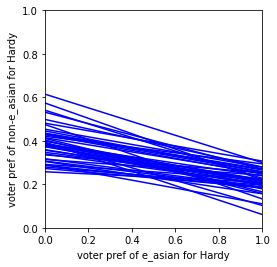

In [60]:
tomography_plot(group_fraction_2by2, votes_fraction_2by2, demographic_group_name=demographic_group_name_2by2, candidate_name=candidate_name_2by2)

# Fit example models

The rest of the plots are applicable to fitted models.

In [61]:
# Create a TwobyTwoEI object
ei_2by2 = TwoByTwoEI(model_name="king99_pareto_modification", pareto_scale=8, pareto_shape=2)

# Fit the model
ei_2by2.fit(group_fraction_2by2, 
       votes_fraction_2by2, 
       precinct_pops, 
       demographic_group_name=demographic_group_name_2by2, 
       candidate_name=candidate_name_2by2, 
       precinct_names=precinct_names, 
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_2, b_1, kappa_2, phi_2, kappa_1, phi_1]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 44 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [62]:
# Create a RowByColumnEI object
ei_rbyc = RowByColumnEI(model_name='multinomial-dirichlet-modified', pareto_shape=100, pareto_scale=100)

# Fit the model
ei_rbyc.fit(group_fractions_rbyc, 
       votes_fractions_rbyc, 
       precinct_pops, 
       demographic_group_names=demographic_group_names_rbyc, 
       candidate_names=candidate_names_rbyc, 
       #precinct_names=precinct_names, 
)

r = 3 rows (demographic groups)
c = 3 columns (candidates or voting outcomes)
number of precincts = 42


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, phi, kappa]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 270 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


In [63]:
# Create a GoodmansER object
goodmans_er = GoodmansER() 

# Fit the model
goodmans_er.fit(
    group_fraction_2by2, 
    votes_fraction_2by2,
    demographic_group_name=demographic_group_name_2by2, 
    candidate_name=candidate_name_2by2
)

In [64]:
# Create a GoodmansERBayes object
bayes_goodman_ei = GoodmansERBayes("goodman_er_bayes", weighted_by_pop=True, sigma=1)

# Fit the model
bayes_goodman_ei.fit(
    group_fraction_2by2, 
    votes_fraction_2by2,
    precinct_pops,
    demographic_group_name=demographic_group_name_2by2, 
    candidate_name=candidate_name_2by2
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b_2, b_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.


# Summary plots for distributions of polity-wide voter preferences

Availplot_intervalsable for fitted `TwoByTwoEI`, `RowByColumEI`, `GoodmansERBayes` objects

- `plot`
- `plot_kde` (2 by 2)
- `plot_kdes` (r by c)
- `plot_boxplot` (2 by 2)
- `plot_boxplots` (r by c)
- `plot_intervals` (2 by 2)

(<AxesSubplot:>, <AxesSubplot:xlabel='Support for Hardy', ylabel='Density'>)

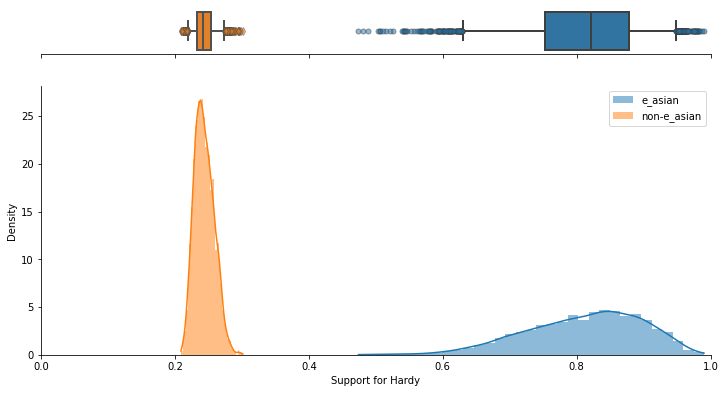

In [65]:
ei_2by2.plot() # Summary plot 

<AxesSubplot:title={'center':'Support for Hardy'}, ylabel='Density'>

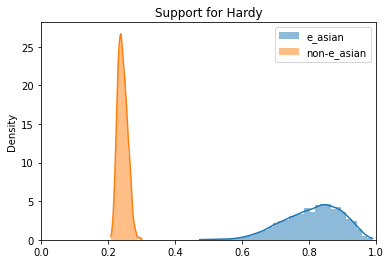

In [66]:
ei_2by2.plot_kde()

<AxesSubplot:title={'center':'Hardy'}>

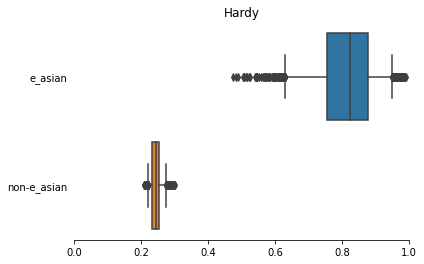

In [67]:
ei_2by2.plot_boxplot()

<AxesSubplot:title={'center':'95% credible intervals'}, xlabel='Support for Hardy'>

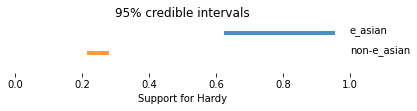

In [68]:
ei_2by2.plot_intervals()

<AxesSubplot:title={'center':'Support for Nadeem'}, ylabel='Density'>

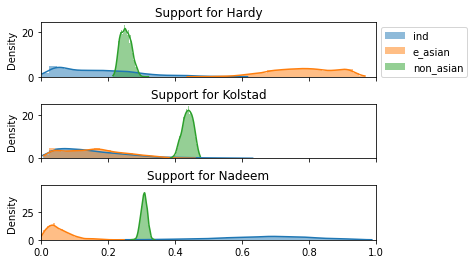

In [69]:
ei_rbyc.plot()

**For r by c kde and boxplots, specify whether you'd like to organize the plots by group or by candidate**

<AxesSubplot:title={'center':'Support among non_asian'}, ylabel='Density'>

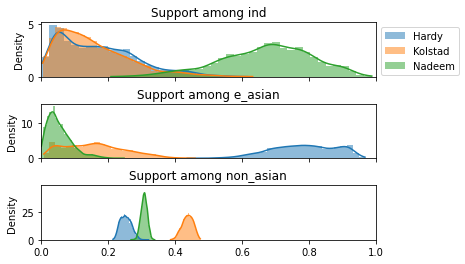

In [70]:
ei_rbyc.plot_kdes(plot_by="group")

<AxesSubplot:title={'center':'Support for Nadeem'}, ylabel='Density'>

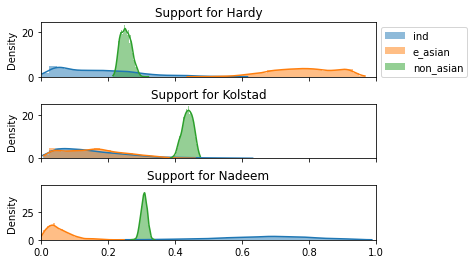

In [71]:
ei_rbyc.plot_kdes(plot_by="candidate")

<AxesSubplot:title={'center':'non_asian'}>

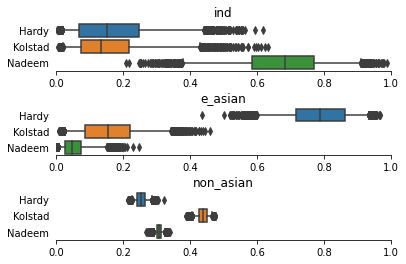

In [72]:
ei_rbyc.plot_boxplots(plot_by="group")

<AxesSubplot:title={'center':'Nadeem'}>

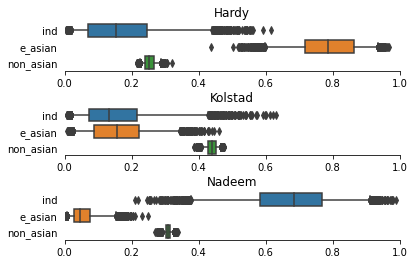

In [73]:
ei_rbyc.plot_boxplots(plot_by="candidate")

In [74]:
ei_rbyc.plot_intervals()

AttributeError: 'RowByColumnEI' object has no attribute 'plot_intervals'

# Plots of polarization

Available for fitted `TwoByTwoEI`, `RowByColumEI`, `GoodmansERBayes` objects.

These plots visualize the estimated difference in support for a candidate between two demographic groups. Thus, they give insight into the polarization of those two groups with respect to a particular candidate.

We can specify either an threshold, and show the probability that the difference in support is at least as large as that threshold.

Alternatively, we can specify a percentile, and show the associated credible interval of the difference in voter support.
For example, we might specify the percentile of 95, and be returned something like: **there is a 95% probability that the difference in support for the candidate is in [.34, .73].** The fact that interval is far from 0 (where 0 represents no difference in support for the candidate between the two groups), suggests that the two groups have very different levels of support for the candidate.

<AxesSubplot:title={'center':'Difference in voter preference for Hardy: e_asian - non-e_asian'}, ylabel='Density'>

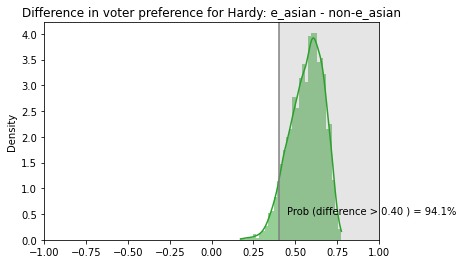

In [75]:
ei_2by2.plot_polarization_kde(threshold=0.4, show_threshold=True) #set show_threshold to false to just view the kde

<AxesSubplot:title={'center':'Difference in voter preference for Hardy: e_asian - non-e_asian'}, ylabel='Density'>

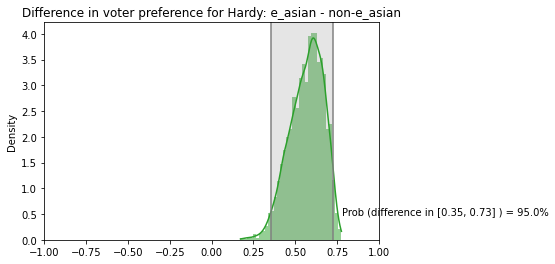

In [76]:
ei_2by2.plot_polarization_kde(percentile=95, show_threshold=True) #set show_threshold to false to just view the kde

<AxesSubplot:title={'center':'Difference in voter preference for Kolstad: ind - e_asian'}, ylabel='Density'>

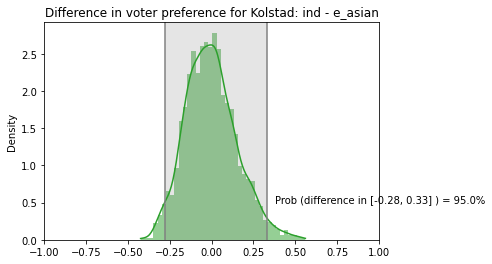

In [77]:
# For the r by c case, we need to specify the two groups we'd like to compare, and the candidate of interest
ei_rbyc.plot_polarization_kde(percentile=95, groups=['ind', 'e_asian'], candidate='Kolstad', show_threshold=True) #set show_threshold to false to just view the kde

# Plots of precinct-level voter preferences

Available for `TwoByTwoEI`, `RowByColumEI` objects.
*(Note that neither GoodmansER approach produce precinct-level estimates)*

- `precinct_level_plot`
- `plot_intervals_by_precinct`

<AxesSubplot:title={'center':'Precinct level estimates of voting preferences'}, xlabel='Percent vote for candidate', ylabel='Precinct'>

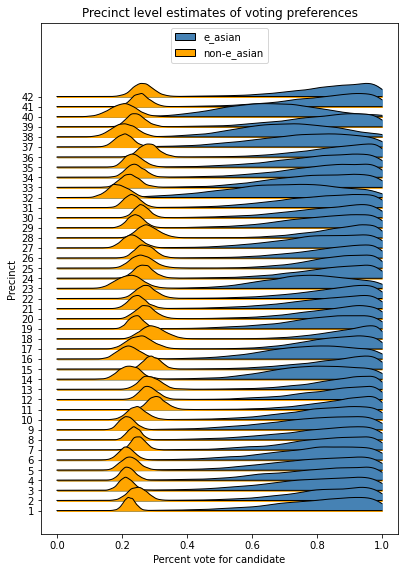

In [78]:
ei_2by2.precinct_level_plot()

In [ ]:
#ei_rbyc.precinct_level_plot()

# GoodmansER plots

Like `TwoByTwoEI`, `RowByColumEI` objects, `GoodmansER` and `GoodmansERBayes` objects have a plot function to show a summary plot; however, since Goodman models rest on a linear regresion, their summary plots visualize that regression, and so look different from the other summary plots.

Note that the y-coordinate of point of intersection of the line with $x=1$ gives the estimated support of the demographic group of interest for the candidate of interest. Note that the y-coordinate of point of intersection of the line with $x=0$ gives the estimated support of the complement of the demographic group of interest for the candidate of interest. 

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Fraction in group e_asian', ylabel='Fraction voting for Hardy'>)

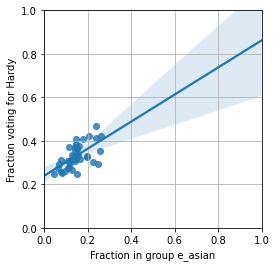

In [79]:
goodmans_er.plot()

<AxesSubplot:xlabel='Fraction in group e_asian', ylabel='Fraction voting for Hardy'>

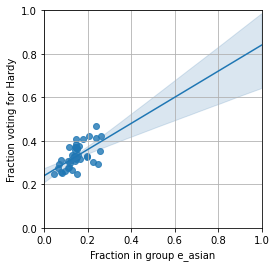

In [80]:
bayes_goodman_ei.plot()

# plot_precinct_scatterplot

This is a method for comparing the outputs of two different ei methods by comparing the point estimates that the two methods give for each precinct.

In [85]:
ei_2by2_alternative = TwoByTwoEI(model_name='truncated_normal')
ei_2by2_alternative.fit(group_fraction_2by2, 
       votes_fraction_2by2, 
       precinct_pops, 
       demographic_group_name=demographic_group_name_2by2, 
       candidate_name=candidate_name_2by2, 
       precinct_names=precinct_names, 
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_2, b_1, d_2, c_2, d_1, c_1]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 65 seconds.
There were 259 divergences after tuning. Increase `target_accept` or reparameterize.
There were 327 divergences after tuning. Increase `target_accept` or reparameterize.
There were 212 divergences after tuning. Increase `target_accept` or reparameterize.
There were 352 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


<AxesSubplot:xlabel='all support for Hardy: king-pareto', ylabel='all support for Hardy: truncated normal'>

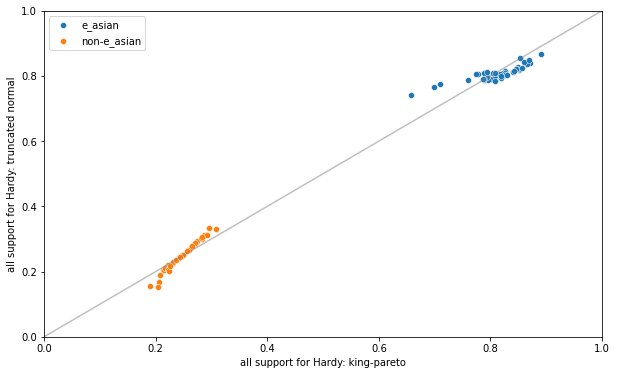

In [125]:
plot_precinct_scatterplot([ei_2by2, ei_2by2_alternative], run_names=['king-pareto', 'truncated normal'], candidate='Hardy')

# Visualizing models

We can use pymc3's `model_to_graphviz` function to visualize the models themselves, by showing the associated graphical model.

Available for `TwoByTwoEI`, `RowByColumnEI`, and `BayesGoodmansER` objects

In [ ]:
model = ei_2by2.sim_model
pm.model_to_graphviz(model)

In [ ]:
model = bayes_goodman_ei.sim_model
pm.model_to_graphviz(model)

# Saving plots

PyEI's plotting functions return matplotlib Axes objects. One simple way to save a figure that you've generated in a notebook is to use matplotlib.pyplot's `savefig` method. We provide an example here, in case you are new to matplotlib.

In [ ]:
import matplotlib.pyplot as plt

goodmans_er.plot()
plt.savefig('goodman_er_testfig.png', dpi=300) # Creates a file named `goodman_er_testfig.png`